# Intro
This notebook is designed to serve as an example of how to manually control a PANOPTES unit using the high-level software interface. It also acts as a basic test of hardware functionality.

#### POCS

`POCS` is a high-level object that acts as the "brains" for the unit. We build an `Observatory` object that has knowledge of our hardware and then pass this object into the `POCS` object instance. While `POCS` is running it is responsible for moving the unit between the various _states_, doing safety checks (weather, darkness, hard drive space, etc.) as well as performing other tasks. So `POCS` decides which commands to send to the `Observatory` based on what _state_ it is in. The `Observatory` is then responsible for controlling individual hardware components.

Normal automated operation of a unit involves creating an `Observatory` and a `POCS` instance, which is then run in a non-interactive fashion, such as:

```python3
observatory = Observatory()
pocs = POCS(observatory)
pocs.initialize()
pocs.run()
```

The `pocs_shell` that is normally used wraps the statements above:

```
Welcome to POCS Shell! Type ? for help
POCS > setup_pocs
POCS > run_pocs
```

In this notebook we are goinng to create the `POCS` and `Observatory` instance but then interact with it manually rather than using the `pocs.run()` method.

---

### Setup

There are a few basic things that need to be set up before:

* Firmware updated for iOptron.
* Set Horizon limits and behaviour via handset (30° for limit and stop as behaviour).
* Define park position on via handset (operation steps below will test this).
* Make sure data has been downloaded  (see below).

##### Log files
You will also probably want to watch the log file. Assuming a standard POCS installation, the log files are in `/var/panoptes/logs/`. When running in a jupyter notebook (such as here), you can run the following in a separate terminal:

```
grc tail -F /var/panoptes/logs/ipykernel_launcher.py-all.log
```

The `grc` portion is optional and needs to be installed on Ubuntu (`sudo apt install grc`) but gives helpful color output to the log file. The `tail` command is standard on all linux systems. The `-F` option just means "follow".

##### Download data

If you need to download data files.  Note that the instructions should have had you set up a cron job which does this same thing every week, see [instructions here](https://github.com/panoptes/POCS/wiki/Cron-Jobs). There is no harm in re-running this but it does not need to be run every time.

In [1]:
from pocs.utils.data import Downloader
Downloader().download_all_files()

True

# Operation

### Initialization

In [2]:
# Load the required modules
from pocs.core import POCS
from pocs.observatory import Observatory
from pocs.utils import error

In [3]:
# Create the observatory object with simulators attached
observatory = Observatory(simulator=['all']) # Could be any of: ['weather', 'night', 'camera', 'mount', 'all']

In [4]:
# Create an instance of POCS and pass it the observatory instance
pocs = POCS(observatory) 

The `pocs` instance needs to be initialized, which will set up the cameras, mount, scheduler, etc.

In [5]:
pocs.initialize()

True

### Test home and park positions

By default the mount is parked when operations start. Here we want to simply unpark the mount, slew to the home position (with RA axis vertical and cameras pointing at Polaris), move around in a few directions, then park.

#### Home

In [6]:
# Easier to work with shorter name
mount = pocs.observatory.mount

# Unpark the mount
mount.unpark()

True

In [7]:
# Slew to home
mount.slew_to_home()

In [8]:
# We can check if at home
mount.is_home

True

In [9]:
# Or if parked
mount.is_parked

False

In [10]:
# Or slewing
mount.is_slewing

False

In [11]:
# Or tracking
mount.is_tracking

False

#### Move direction

We want to simply move the mount around a bit to test that directions work.

In [24]:
# Set mount to move at the fastest speed for manual movements
# Note: there is no high-level method for doing this so we use the underlying `query`
# command to send commands and values. This is not a common procedure as we normally
# leave it at the fastest speed.
mount.query('set_button_moving_rate', 9)

In [13]:
# Slew the Dec south
mount.move_direction(direction='south', seconds=3)

In [14]:
# Slew the RA to the west
mount.move_direction(direction='west', seconds=3)

In [26]:
# Set a slower speed just to test visible difference, then move again
# Note: it can be hard to tell the mount is even moving at slower speeds
mount.query('set_button_moving_rate', 7)
mount.move_direction(direction='north', seconds=3)
mount.move_direction(direction='east', seconds=3)

Since the above was at a slower movement rate this should not return to the exact home position. 

In [25]:
# Reset movement speed
mount.query('set_button_moving_rate', 9)

#### Park

When parking we usually want to first go home and then park:

In [16]:
mount.home_and_park()

In [17]:
mount.is_home

False

In [18]:
mount.is_parked

True

##### Status

We can check the status of the mount at any time. Right now this won't contain much information but once we have acquired a target you will see more information here:

In [19]:
mount.status()

{'tracking_rate': '1.0000',
 'ra_guide_rate': 0.5,
 'dec_guide_rate': 0.5,
 'movement_speed': '',
 'current_ra': <Longitude 11.87005046 deg>,
 'current_dec': <Latitude -10. deg>,
 'timestamp': <Time object: scale='utc' format='datetime' value=2018-08-09 06:12:31.646216>,
 'tracking_rate_ra': 1.0,
 'state': 'Parked'}

Note that we can also check the status on our `pocs` instance, which will recursively call `status` for all the objects in knows about. Again, this will also include target information as appropriate.

In [20]:
pocs.status()

{'state': 'sleeping',
 'system': {'free_space': 13.258313728000001},
 'observatory': {'mount': {'tracking_rate': '1.0000',
   'ra_guide_rate': 0.5,
   'dec_guide_rate': 0.5,
   'movement_speed': '',
   'current_ra': <Longitude 11.87005046 deg>,
   'current_dec': <Latitude -10. deg>,
   'timestamp': <Time object: scale='utc' format='datetime' value=2018-08-09 06:12:31.672009>,
   'tracking_rate_ra': 1.0,
   'state': 'Parked',
   'current_ha': <Longitude 12.67120839 hourangle>},
  'observer': {'siderealtime': '13h27m45.4834s',
   'utctime': <Time object: scale='utc' format='datetime' value=2018-08-09 06:12:31.669894>,
   'localtime': '2018-08-09 16:12:31',
   'local_evening_astro_time': <Time object: scale='utc' format='jd' value=2458339.8656154433>,
   'local_morning_astro_time': <Time object: scale='utc' format='jd' value=2458340.3022836037>,
   'local_sun_set_time': <Time object: scale='utc' format='jd' value=2458339.803693587>,
   'local_sun_rise_time': <Time object: scale='utc' form

### Slew to position, take images

We want to give the mount a valid target, have it slew to and acquire target, then take an image with the cameras.

Here we create a target from a set of AltAz coordinates. Normally the targets are specifcied in an external targets file and the `pocs.observatory.get_observation` method is responsible for running the scheduler to detremine the most appropriate object.

In [30]:
from pocs.utils import altaz_to_radec
from pocs.utils import current_time

In [34]:
# Create a target for the given AltAz coordinates. To create AltAz we need to know where
# on earth we are and at what time we are looking.

alt = 70
az = 90

target = altaz_to_radec(
    alt=alt, 
    az=az, 
    location=pocs.observatory.earth_location, 
    obstime=current_time()
)

target

<SkyCoord (ICRS): (ra, dec) in deg
    (236.09174716, -31.43589531)>

In [35]:
# Make sure our mount is unparked
mount.unpark()

True

In [36]:
mount.set_target_coordinates(target)

True

In [38]:
mount.slew_to_target()

True

In [40]:
mount.is_tracking

True

In [42]:
# Track when camera is done exposing
camera_events = dict()

# Take exposure with each camera
for cam_name, camera in pocs.observatory.cameras.items():

    try:
        # Start the exposures
        cam_event = camera.take_exposure(
            seconds=2,
            filename='/var/panoptes/images/temp/test_pic_{}.cr2'.format(cam_name)
        )

        camera_events[cam_name] = cam_event
    except Exception as e:
        print("Problem waiting for images: {}".format(e))        

In [50]:
# See our stored events
camera_events

{'Cam00': <threading.Event at 0x7f294bad7ba8>,
 'Cam01': <threading.Event at 0x7f294c266860>}

In [51]:
# We can check if the event is complete
camera_events['Cam00'].is_set()

True

Now let's very we got a picture by making a jpg

In [62]:
# Show images in the notebook
from IPython.display import display, Image

from pocs.utils.images import make_pretty_image

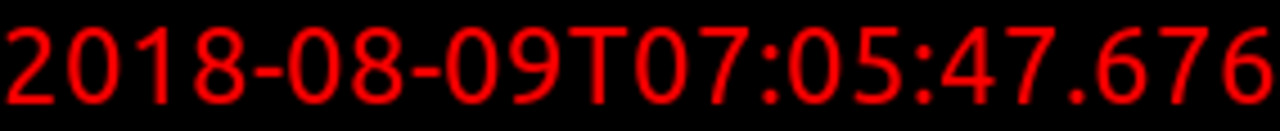

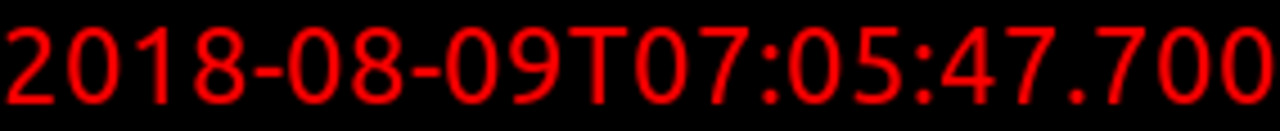

In [63]:
# Turn it into a pretty image
for cam_name in pocs.observatory.cameras.keys():
    jpg_fn = make_pretty_image('/var/panoptes/images/temp/test_pic_{}.cr2'.format(cam_name))
    display(Image(jpg_fn))

### Scheduler - Add a custom target

In [21]:
# Remove all possible observations
obs_names = [o for o in pocs.observatory.scheduler.observations]
for obs_name in obs_names:
    pocs.observatory.scheduler.remove_observation(obs_name)

Below we are setting the target to HD 189733 just as an example. If you are running this notebook in the daytime and want to actually go to a target, change the below to a target that is up (at least 30° above horizon) and make sure to include the `night` simulator when constructing the `Observatory` object, i.e.: `Observatory(simulator=['night', 'weather'])`.

In [27]:
# Set a new high priority target.
target = {
    'name': 'HD 189733',
    'position': '20h00m43.713s +22d42m39.07s',
    'priority': 999,
    'exp_time': 45,
}

pocs.observatory.scheduler.add_observation(target)

In [23]:
# Get a new observation, which should be our new event
try:
    new_obs = pocs.observatory.get_observation(reread_fields_file=False)  # Don't want to add default targets back
except error.NoObservation:
    print("No targets available")

No targets available
